In [1]:
# ============================================================
# Trial11: Trial10 + (OPTION 1) Weighted Cycle-Loss (recommended)
# - Goal: keep "cycle-scale training/selection" BUT remove RUL0-scale dominance
#
# 핵심 변경 (vs Trial10):
#   1) Training loss:
#        Trial10: MSE(pred_cycles, y_cycles)
#        Trial11: MSE( (pred_cycles - y_cycles) / rul0 , 0 )  == mean( ((pred_cycles-y_cycles)/rul0)^2 )
#      => 파일별 RUL0 크기에 덜 끌리고, 일반화가 좋아질 확률↑
#
#   2) Best checkpoint rule 그대로:
#        best_by_val_cycles (val_rmse_cycles 최소)
#
# - EVAL ONLY (from Trial9) 그대로 포함:
#     * windows -> cycle mean representative
#     * PH / α–λ / CRA / convergence
#     * paper-style figures (α+PH, α–λ single λ)
# ============================================================

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config (Trial11)
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial11"

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all
    num_workers: int = 0

    # ===========================
    # Trial11: Weighted cycle-loss settings
    # ===========================
    eps_rul0: float = 1e-8  # avoid div by zero

    # ===========================
    # Evaluation settings (from Trial9)
    # ===========================
    alpha: float = 0.20
    ph_consecutive_m: int = 5
    rep_method: str = "mean"
    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)
    lambda_to_plot: float = 0.6
    eps_rul: float = 1e-8


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")

    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")

    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def compute_dvce(vce: np.ndarray) -> np.ndarray:
    dv = np.zeros_like(vce, dtype=np.float32)
    dv[1:] = vce[1:] - vce[:-1]
    return dv


# ============================================================
# 3) Dataset
# ============================================================
class WindowedRULDatasetNorm2F(Dataset):
    def __init__(
        self,
        file_list: List[Path],
        seq_len: int,
        stride: int,
        pred_horizon: int,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
    ):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()

        # store: (name, X2(T,2), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            dv = compute_dvce(vce)
            x2 = np.stack([vce, dv], axis=1).astype(np.float32)  # (T,2)
            self.series.append((fp.name, x2, rul.astype(np.float32), rul0))

        if fit_scaler:
            all_x = np.concatenate([x2 for _, x2, _, _ in self.series], axis=0)
            self.scaler_x.fit(all_x)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, x2, _rul, _rul0) in enumerate(self.series):
            T = x2.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, x2, rul, rul0 = self.series[fi]

        x = x2[s:s + self.seq_len, :]
        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 4) Model
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)  # (B,1) norm-scale


# ============================================================
# 5) Basic eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        # norm metrics
        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        # cycle metrics
        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 6) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 7) Prognostics metrics (PH / α–λ / CRA / convergence)
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    # PH start: M consecutive in_alpha
    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    # α–λ
    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:
    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 8) Plotters
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")
        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--",
                     label=f"+{alpha:.2f} alpha–lambda accuracy zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--",
                     label=f"-{alpha:.2f} alpha–lambda accuracy zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 9) One seed run (Trial11 training + Trial9 eval outputs)
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    # split
    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    # save split lists
    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    # datasets (fit scaler on train only)
    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNorm2F(
        splits["train"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=scaler_x, fit_scaler=True
    )
    val_ds = WindowedRULDatasetNorm2F(
        splits["val"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=train_ds.scaler_x, fit_scaler=False
    )
    test_ds = WindowedRULDatasetNorm2F(
        splits["test"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=train_ds.scaler_x, fit_scaler=False
    )

    pd.DataFrame({
        "feature": ["min_vce", "d_min_vce"],
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    # model
    model = LSTMRegressor(
        input_size=2,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    # best checkpoint rule: val_rmse_cycles
    best_by_val_cycles = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_cycles.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, _y_norm, _name, _s, y_cycles, rul0 in train_loader:
            x = x.to(device)
            y_cycles = y_cycles.to(device).view(-1, 1)
            rul0 = rul0.to(device).view(-1, 1)

            optimizer.zero_grad()

            pred_norm = model(x)
            pred_cycles = pred_norm * rul0

            # ============================
            # Trial11 핵심: weighted cycle-loss
            # loss = mean( ((pred_cycles - y_cycles)/rul0)^2 )
            # ============================
            denom = torch.clamp(rul0, min=cfg.eps_rul0)
            err_norm_like = (pred_cycles - y_cycles) / denom
            loss = torch.mean(err_norm_like ** 2)

            loss.backward()
            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()

            losses.append(loss.item())

        train_weighted_mse = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_weighted_mse": train_weighted_mse,
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
        })

        # best 기준: val_rmse_cycles
        if val_metrics["rmse_cycles"] < best_by_val_cycles:
            best_by_val_cycles = val_metrics["rmse_cycles"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_weighted_mse={train_weighted_mse:.6f} | "
                f"val_rmse_cycles={val_metrics['rmse_cycles']:.3f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_cycles={best_by_val_cycles:.3f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        # save preds + metrics/figures
        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name}",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,

            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],

            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],

            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],

            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_cycles": best_by_val_cycles,

            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(
            f"[SEED {seed}] {tag}: "
            f"VAL rmse_cycles={va['rmse_cycles']:.3f}, mae_cycles={va['mae_cycles']:.3f} | "
            f"TEST rmse_cycles={te['rmse_cycles']:.3f}, mae_cycles={te['mae_cycles']:.3f}"
        )
        return ms

    ms_best = export_ckpt("best_by_val_cycles", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 10) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial11_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial11 folder:")
    print(" - per seed results: Trial11/seed_<seed>/...")
    print(" - paper figures: seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle seq mean: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 11) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial11",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        eps_rul0=1e-8,

        # eval settings
        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),
        lambda_to_plot=0.6,
    )

    run_trial11_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial11\seed_9819123
[SEED 9819123] [001/300] train_weighted_mse=0.039145 | val_rmse_cycles=3303.883 | val_mae_cycles=2457.076 | best_val_rmse_cycles=3303.883
[SEED 9819123] [010/300] train_weighted_mse=0.049197 | val_rmse_cycles=3153.491 | val_mae_cycles=2336.496 | best_val_rmse_cycles=3126.093
[SEED 9819123] [020/300] train_weighted_mse=0.021909 | val_rmse_cycles=3233.410 | val_mae_cycles=2385.679 | best_val_rmse_cycles=3113.272
[SEED 9819123] [030/300] train_weighted_mse=0.020806 | val_rmse_cycles=3461.328 | val_mae_cycles=2415.187 | best_val_rmse_cycles=3091.084
[SEED 9819123] [040/300] train_weighted_mse=0.016961 | val_rmse_cycles=3621.615 | val_mae_cycles=2432.724 | best_val_rmse_cycles=3091.084
[SEED 9819123] [050/300] train_weighted_mse=0.004363 | val_rmse_cycles=3423.581 | val_mae_cycles=2375.014 | best_val_rmse_cycles=3091.084
[SEED 9819123] Early stopping at epoch 59.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] best_by_val_cycles: VAL rmse_cycles=3091.084, mae_cycles=2288.161 | TEST rmse_cycles=1647.133, mae_cycles=1133.475


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] last_epoch: VAL rmse_cycles=3625.272, mae_cycles=2480.304 | TEST rmse_cycles=2056.218, mae_cycles=1367.794

[SEED 111] device=cuda
[SEED 111] out=./Trial11\seed_111
[SEED 111] [001/300] train_weighted_mse=0.044485 | val_rmse_cycles=3762.690 | val_mae_cycles=2563.945 | best_val_rmse_cycles=3762.690
[SEED 111] [010/300] train_weighted_mse=0.023880 | val_rmse_cycles=3994.176 | val_mae_cycles=2724.106 | best_val_rmse_cycles=3719.708
[SEED 111] [020/300] train_weighted_mse=0.019884 | val_rmse_cycles=4016.354 | val_mae_cycles=2734.159 | best_val_rmse_cycles=3719.708
[SEED 111] [030/300] train_weighted_mse=0.014272 | val_rmse_cycles=4689.584 | val_mae_cycles=3029.132 | best_val_rmse_cycles=3719.708
[SEED 111] Early stopping at epoch 32.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] best_by_val_cycles: VAL rmse_cycles=3719.708, mae_cycles=2517.583 | TEST rmse_cycles=3694.665, mae_cycles=2292.821


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] last_epoch: VAL rmse_cycles=4929.633, mae_cycles=3202.295 | TEST rmse_cycles=2714.217, mae_cycles=1702.677

[SEED 222] device=cuda
[SEED 222] out=./Trial11\seed_222
[SEED 222] [001/300] train_weighted_mse=0.037182 | val_rmse_cycles=2567.027 | val_mae_cycles=1742.052 | best_val_rmse_cycles=2567.027
[SEED 222] [010/300] train_weighted_mse=0.022092 | val_rmse_cycles=2641.186 | val_mae_cycles=1715.973 | best_val_rmse_cycles=2541.242
[SEED 222] [020/300] train_weighted_mse=0.019378 | val_rmse_cycles=2562.231 | val_mae_cycles=1633.343 | best_val_rmse_cycles=2400.351
[SEED 222] [030/300] train_weighted_mse=0.007679 | val_rmse_cycles=2727.231 | val_mae_cycles=1712.680 | best_val_rmse_cycles=2400.351
[SEED 222] [040/300] train_weighted_mse=0.000622 | val_rmse_cycles=2782.379 | val_mae_cycles=1766.637 | best_val_rmse_cycles=2400.351
[SEED 222] Early stopping at epoch 47.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] best_by_val_cycles: VAL rmse_cycles=2400.351, mae_cycles=1589.989 | TEST rmse_cycles=2691.902, mae_cycles=1891.933


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] last_epoch: VAL rmse_cycles=2720.179, mae_cycles=1732.897 | TEST rmse_cycles=3515.189, mae_cycles=2415.670

[SEED 333] device=cuda
[SEED 333] out=./Trial11\seed_333
[SEED 333] [001/300] train_weighted_mse=0.041292 | val_rmse_cycles=2400.113 | val_mae_cycles=1619.334 | best_val_rmse_cycles=2400.113
[SEED 333] [010/300] train_weighted_mse=0.024098 | val_rmse_cycles=2437.700 | val_mae_cycles=1633.408 | best_val_rmse_cycles=2279.313
[SEED 333] [020/300] train_weighted_mse=0.020821 | val_rmse_cycles=2345.180 | val_mae_cycles=1610.575 | best_val_rmse_cycles=2254.316
[SEED 333] [030/300] train_weighted_mse=0.014833 | val_rmse_cycles=2770.773 | val_mae_cycles=1755.308 | best_val_rmse_cycles=2254.316
[SEED 333] [040/300] train_weighted_mse=0.000980 | val_rmse_cycles=2968.037 | val_mae_cycles=1953.960 | best_val_rmse_cycles=2254.316
[SEED 333] Early stopping at epoch 44.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] best_by_val_cycles: VAL rmse_cycles=2254.316, mae_cycles=1569.147 | TEST rmse_cycles=1827.847, mae_cycles=1161.938


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] last_epoch: VAL rmse_cycles=2913.581, mae_cycles=1924.587 | TEST rmse_cycles=1809.710, mae_cycles=1102.009

[SEED 444] device=cuda
[SEED 444] out=./Trial11\seed_444
[SEED 444] [001/300] train_weighted_mse=0.039325 | val_rmse_cycles=3348.574 | val_mae_cycles=2096.386 | best_val_rmse_cycles=3348.574
[SEED 444] [010/300] train_weighted_mse=0.022599 | val_rmse_cycles=3631.418 | val_mae_cycles=2254.189 | best_val_rmse_cycles=3348.574
[SEED 444] [020/300] train_weighted_mse=0.022335 | val_rmse_cycles=3528.354 | val_mae_cycles=2180.479 | best_val_rmse_cycles=3348.574
[SEED 444] [030/300] train_weighted_mse=0.021057 | val_rmse_cycles=3564.005 | val_mae_cycles=2198.192 | best_val_rmse_cycles=3348.574
[SEED 444] Early stopping at epoch 31.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] best_by_val_cycles: VAL rmse_cycles=3348.574, mae_cycles=2096.386 | TEST rmse_cycles=2226.443, mae_cycles=1599.387


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_41012\1991876804.py:774: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] last_epoch: VAL rmse_cycles=3513.876, mae_cycles=2195.907 | TEST rmse_cycles=2288.341, mae_cycles=1616.769
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=2, best wins=3, ties=0 | mean(last-best)=25.073159, std(last-best)=368.300410
- test_rmse_cycles: last wins=2, best wins=3, ties=0 | mean(last-best)=59.137110, std(last-best)=598.849377
- test_mae_norm: last wins=3, best wins=2, ties=0 | mean(last-best)=-0.002238, std(last-best)=0.022262
- test_rmse_norm: last wins=2, best wins=3, ties=0 | mean(last-best)=-0.000548, std(last-best)=0.027496

=== MEAN ± STD across seeds (TEST) ===
                   test_mae_cycles             test_rmse_cycles              \
                              mean         std             mean         std   
checkpoint                                                                    
best_by_val_cycles     1615.910613  493.331646      2417.598136  819.161740   
last_epoch             1640.983772  492.355836      247

In [2]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial11 paths
# ============================
TRIAL11_DIR = "./Trial11"
SUMMARY_CSV = os.path.join(TRIAL11_DIR, "summary_across_seeds.csv")

# Trial11 checkpoint tags (same as Trial10)
BEST_TAG = "best_by_val_cycles"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule (lower is better):
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # 1) VAL 기준 best (권장)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (참고)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse_cyc = win_rate(df, "val_rmse_cycles")
    wr_test_rmse_cyc = win_rate(df, "test_rmse_cycles")

    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # (선택) MAE도 보고 싶으면 켜기
    wr_val_mae_cyc = win_rate(df, "val_mae_cycles")
    wr_test_mae_cyc = win_rate(df, "test_mae_cycles")
    wr_val_mae_norm = win_rate(df, "val_mae_norm")
    wr_test_mae_norm = win_rate(df, "test_mae_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial11) ================")
    print("[SELECTED BY VAL]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")

    print("\n[SELECTED BY TEST] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_cycles) ----------------")
    def _print_wr(wr):
        print(f"- {wr['metric']}: last wins={wr['wins_last']}, "
              f"best wins={wr['wins_best']}, ties={wr['ties']} | "
              f"mean(last-best)={wr['mean(last-best)']:.6f}")

    _print_wr(wr_val_rmse_cyc)
    _print_wr(wr_test_rmse_cyc)
    _print_wr(wr_val_rmse_norm)
    _print_wr(wr_test_rmse_norm)

    # MAE win-rate도 참고로 출력
    _print_wr(wr_val_mae_cyc)
    _print_wr(wr_test_mae_cyc)
    _print_wr(wr_val_mae_norm)
    _print_wr(wr_test_mae_norm)

    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL11_DIR, "BEST_MODEL_BY_VAL.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial11) - Selected by VAL (rmse_cycles then mae_cycles)\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")

        # Trial11 summary에는 eval meta도 같이 들어감 (있으면 저장)
        for k in ["alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot", "best_val_rmse_cycles", "stopped_epoch"]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial11) ================
[SELECTED BY VAL]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_cycles
  VAL  RMSE (cyc)   : 2254.316
  VAL  MAE  (cyc)   : 1569.147
  VAL  RMSE (norm)  : 0.139227
  VAL  MAE  (norm)  : 0.108803
  TEST RMSE (cyc)   : 1827.847
  TEST MAE  (cyc)   : 1161.938
  TEST RMSE (norm)  : 0.175635
  TEST MAE  (norm)  : 0.142204

[SELECTED BY TEST] (for reporting only; not for tuning)
  Seed             : 9819123
  Checkpoint       : best_by_val_cycles
  TEST RMSE (cyc)   : 1647.133
  TEST MAE  (cyc)   : 1133.475
  TEST RMSE (norm)  : 0.121155
  TEST MAE  (norm)  : 0.094147
  VAL  RMSE (cyc)   : 3091.084
  VAL  MAE  (cyc)   : 2288.161
  VAL  RMSE (norm)  : 0.174583
  VAL  MAE  (norm)  : 0.144971

---------------- WIN-RATE (last_epoch vs best_by_val_cycles) ----------------
- val_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=577.701816
- test_rmse_cycles: last wins=2, best wins=3

In [3]:
import os
import pandas as pd
import numpy as np

# =========================
# USER CONFIG (Trial11)
# =========================
TRIAL_DIR = r"./Trial11"            # Trial11 루트 폴더
SEED = 333                          # 선택된 seed

# Trial11 checkpoint tag:
#  - "best_by_val_cycles"  (recommended)
#  - "last_epoch"
CKPT = "best_by_val_cycles"

SPLITS = ["train", "val", "test"]   # 평가할 split
LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]

# (선택) 후반 λ를 더 중요하게 보고 싶으면 가중치 사용 (기본 None이면 단순 평균)
# 예: λ=0.2,0.4,0.6,0.8 가중치 = 1,1,2,3
LAMBDA_WEIGHTS = None  # 또는 {"0.20": 1, "0.40": 1, "0.60": 2, "0.80": 3}


# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}

    # per-lambda
    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        rates[f"rate_{ls}"] = float(dfm[col].mean()) if col in dfm.columns else np.nan

    # overall
    if weights is None:
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        num, den = 0.0, 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates


def main():
    # Trial11 폴더 구조:
    #   ./Trial11/seed_<seed>/<CKPT>/
    #   예) ./Trial11/seed_333/best_by_val_cycles/
    ckpt_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)
    if not os.path.isdir(ckpt_dir):
        raise FileNotFoundError(
            f"Not found: {ckpt_dir}\n"
            f"Check TRIAL_DIR/SEED/CKPT.\n"
            f"CKPT should be 'best_by_val_cycles' or 'last_epoch'."
        )

    out_dir = os.path.join(ckpt_dir, "alpha_lambda_eval")
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []

    for split in SPLITS:
        # Trial11 export 위치: <ckpt_dir>/<split>_prognostics_metrics_per_file.csv
        mpath = os.path.join(ckpt_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)
        _require_cols(dfm, ["file"])  # 최소 file은 있어야 함

        # split 요약(성공률)
        rates = compute_alpha_lambda_rates(dfm, LAM_STRS, weights=LAMBDA_WEIGHTS)
        row = {
            "trial_dir": TRIAL_DIR,
            "seed": SEED,
            "checkpoint": CKPT,
            "split": split,
            "n_files": int(len(dfm)),
            **rates
        }
        summary_rows.append(row)

        # (선택) 파일별 pass/fail 저장
        keep_cols = ["file"]
        for ls in LAM_STRS:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)

        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", CKPT)
        sub.insert(0, "seed", SEED)
        per_file_rows.append(sub)

        # 콘솔 출력
        parts = []
        for ls in LAM_STRS:
            v = row.get(f"rate_{ls}", np.nan)
            if np.isfinite(v):
                parts.append(f"λ={ls}:{v:.3f}")
        overall_key = "rate_weighted_all" if LAMBDA_WEIGHTS is not None else "rate_mean_all"
        overall = row.get(overall_key, np.nan)
        if np.isfinite(overall):
            parts.append(f"overall:{overall:.3f}")
        print(f"[OK] {split}: " + ", ".join(parts))

    # 저장: split별 요약
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv")
    df_summary.to_csv(out_summary, index=False)

    # 저장: 파일별 pass/fail (선택)
    out_pf = None
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, f"alpha_lambda_per_file_seed{SEED}_{CKPT}.csv")
        df_pf.to_csv(out_pf, index=False)

    print("\n==================== DONE ====================")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")

if __name__ == "__main__":
    main()


[OK] train: λ=0.20:0.729, λ=0.40:0.429, λ=0.60:0.243, λ=0.80:0.229, overall:0.407
[OK] val: λ=0.20:0.600, λ=0.40:0.650, λ=0.60:0.350, λ=0.80:0.200, overall:0.450
[OK] test: λ=0.20:0.700, λ=0.40:0.600, λ=0.60:0.200, λ=0.80:0.300, overall:0.450

==================== DONE ====================
Saved:
 - ./Trial11\seed_333\best_by_val_cycles\alpha_lambda_eval\alpha_lambda_summary_seed333_best_by_val_cycles.csv
 - ./Trial11\seed_333\best_by_val_cycles\alpha_lambda_eval\alpha_lambda_per_file_seed333_best_by_val_cycles.csv


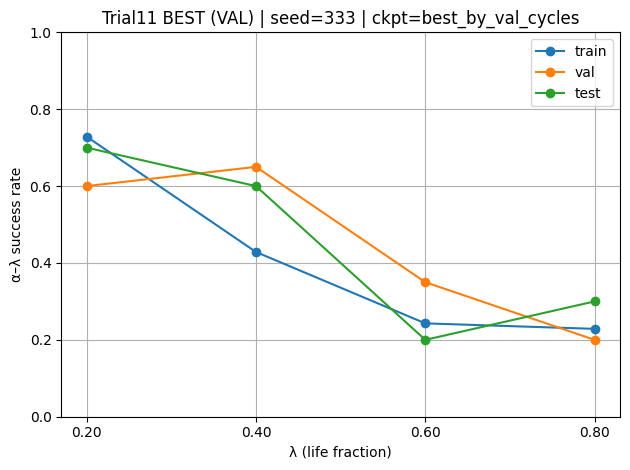

[BEST] selected by VAL (val_rmse_cycles, val_mae_cycles)
  seed=333, checkpoint=best_by_val_cycles
[READ] ./Trial11\seed_333\best_by_val_cycles\alpha_lambda_eval\alpha_lambda_summary_seed333_best_by_val_cycles.csv
[SAVE] ./alpha_lambda_curve_best_trial11.png


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial11)
# =========================
TRIAL11_DIR = r"./Trial11"  # 또는 r"C:\...\Trial11"
OUT_PNG = r"./alpha_lambda_curve_best_trial11.png"

LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]
LAM = [float(x) for x in LAM_STRS]
SPLITS_ORDER = ["train", "val", "test"]

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

def pick_best_row_by_val_cycles(summary_csv: str) -> pd.Series:
    """
    Trial11 summary_across_seeds.csv에서
    VAL 기준 best 모델 1개 선택:
      1) val_rmse_cycles 최소
      2) val_mae_cycles 최소 (tie-break)
    """
    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Not found: {summary_csv}")

    df = pd.read_csv(summary_csv)
    _require_cols(df, ["seed", "checkpoint", "val_rmse_cycles", "val_mae_cycles"])

    df_sorted = df.sort_values(
        by=["val_rmse_cycles", "val_mae_cycles"],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]

def find_alpha_lambda_summary_csv(trial_dir: str, seed: int, ckpt: str) -> str:
    """
    Trial11 구조 기준:
      <trial_dir>/seed_<seed>/<ckpt>/alpha_lambda_eval/alpha_lambda_summary_seed<seed>_<ckpt>.csv
    """
    cand = os.path.join(
        trial_dir,
        f"seed_{seed}",
        ckpt,
        "alpha_lambda_eval",
        f"alpha_lambda_summary_seed{seed}_{ckpt}.csv"
    )
    if os.path.exists(cand):
        return cand

    # fallback: alpha_lambda_eval 폴더 내 summary csv 아무거나 찾기
    alt_dir = os.path.join(trial_dir, f"seed_{seed}", ckpt, "alpha_lambda_eval")
    if os.path.isdir(alt_dir):
        for fn in os.listdir(alt_dir):
            fn_low = fn.lower()
            if fn_low.startswith("alpha_lambda_summary") and fn_low.endswith(".csv"):
                return os.path.join(alt_dir, fn)

    raise FileNotFoundError(
        "alpha-lambda summary csv not found.\n"
        f"Expected: {cand}\n"
        f"Also checked: {alt_dir}"
    )

# =========================
# Main
# =========================
def main():
    summary_csv = os.path.join(TRIAL11_DIR, "summary_across_seeds.csv")

    best = pick_best_row_by_val_cycles(summary_csv)
    best_seed = int(best["seed"])
    best_ckpt = str(best["checkpoint"])

    summary_path = find_alpha_lambda_summary_csv(TRIAL11_DIR, best_seed, best_ckpt)
    df = pd.read_csv(summary_path)
    _require_cols(df, ["split"] + [f"rate_{ls}" for ls in LAM_STRS])

    # plot
    plt.figure()
    for split in SPLITS_ORDER:
        sub = df[df["split"] == split]
        if sub.empty:
            continue
        row = sub.iloc[0]
        rates = [float(row.get(f"rate_{ls}", np.nan)) for ls in LAM_STRS]
        plt.plot(LAM, rates, marker="o", label=split)

    plt.xticks(LAM, [f"{x:.2f}" for x in LAM])
    plt.ylim(0, 1.0)
    plt.xlabel("λ (life fraction)")
    plt.ylabel("α–λ success rate")
    plt.grid(True)
    plt.legend()
    plt.title(f"Trial11 BEST (VAL) | seed={best_seed} | ckpt={best_ckpt}")
    plt.tight_layout()

    plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
    plt.show()

    print("[BEST] selected by VAL (val_rmse_cycles, val_mae_cycles)")
    print(f"  seed={best_seed}, checkpoint={best_ckpt}")
    print(f"[READ] {summary_path}")
    print(f"[SAVE] {OUT_PNG}")

if __name__ == "__main__":
    main()


In [5]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG (Trial11)
# ============================================================
TRIAL_DIR = r"./Trial11"              # ✅ Trial11 폴더
SEED = 333                            # 선택된 seed
CKPT = "best_by_val_cycles"           # ✅ Trial11 checkpoint: "best_by_val_cycles" or "last_epoch"

SPLITS = ["train", "val", "test"]     # 여러 split 한번에

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60                 # α–λ 그림에 표시할 λ

MAX_FILES = None                      # None=모두, 아니면 예: 10

# 저장 폴더 루트 (Trial11 구조: seed_<seed>/<ckpt>/ 아래에 저장)
OUT_ROOT = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")

def load_cycle_seq_and_metrics(ckpt_dir: str, split: str):
    """
    Trial11 export 단계가 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    위치: ./Trial11/seed_<seed>/<ckpt>/
    """
    seq_csv = os.path.join(ckpt_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(ckpt_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met

def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df

# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일:
    - PH용 α-zone = '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # 평행 밴드 폭
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일:
    - α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(ckpt_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(ckpt_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")

def main():
    # Trial11 구조: ./Trial11/seed_<seed>/<ckpt>/
    ckpt_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)
    if not os.path.isdir(ckpt_dir):
        raise FileNotFoundError(f"Not found: {ckpt_dir}")

    for split in SPLITS:
        run_for_one_split(ckpt_dir, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)

if __name__ == "__main__":
    main()


[train] DONE -> ./Trial11\seed_333\best_by_val_cycles\paper_figures_bookstyle\train
[val] DONE -> ./Trial11\seed_333\best_by_val_cycles\paper_figures_bookstyle\val
[test] DONE -> ./Trial11\seed_333\best_by_val_cycles\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial11\seed_333\best_by_val_cycles\paper_figures_bookstyle
